# Objective:
### I want to produce a time series of all my '202X_liked_songs' playlists from 2018 to 2023 to measure trends in spotify analytics like: `valance`, `danceability`, `happiness`, etc. in my music preferences.


In [11]:
import pandas as pd
import numpy as np
import json
import os

### `fun main(effort) {`
    #let's begin
`}`

## Helper Functions

In [12]:
def appendPlaylsit(playlist: pd.Series, playlistName: str, master: pd.DataFrame) -> pd.DataFrame:
    '''
    Appends the song and playlist info of a playlist to the master dataframe
    '''
    staging = []
    for track in playlist:
        trackDetails = track['track']
        newRow = {
            'playlist': playlistName, 
            'trackName': trackDetails['trackName'], 
            'artistName': trackDetails['artistName'],
            'albumName': trackDetails['albumName'], 
            'trackUri': trackDetails['trackUri'],
            }
        staging.append(newRow)
    df_staging = pd.DataFrame(staging, columns=master.columns)
    return pd.concat([master, df_staging], ignore_index=True)


def appendCurrentPlaylist(playlist: dict, playlistName: str, master: pd.DataFrame) -> pd.DataFrame:
    '''
    Appends the song and playlist info of the current year's "Liked Songs" playlist
    to the master dataframe.
    '''
    staging = []
    for track in playlist['tracks']:
        newRow = {
            'playlist': playlistName,
            'trackName': track['track'],
            'artistName': track['artist'],
            'albumName': track['album'], 
            'trackUri': track['uri'],
            }
        staging.append(newRow)
    df_staging = pd.DataFrame(staging, columns=master.columns)
    return pd.concat([master, df_staging], ignore_index=True)


def getCurrentPlaylist(path: str):
    '''
    Loads the current "Liked Songs" playlist as a dictionary
    '''
    with open(path, encoding='utf-8') as json_data:
        data = json.load(json_data)
    return data
    

def getStreamHistory(extendedDataPath: str, historyFilePath: str) -> pd.DataFrame:
    return (pd.read_json(os.path.join(extendedDataPath, historyFilePath))
            .drop(columns=[
                'username',
                'platform',
                'conn_country',
                'ip_addr_decrypted',
                'user_agent_decrypted',
                'master_metadata_album_album_name',
                'episode_name','episode_show_name',
                'spotify_episode_uri',
                'incognito_mode',
                ],
                  )
            .rename(columns={
                'ts': 'timeStamp',
                'ms_played': 'msPlayed',
                'master_metadata_track_name': 'trackName',
                'master_metadata_album_artist_name': 'artistName',
                'spotify_track_uri': 'trackUri',
                'reason_start': 'reasonStart',
                'reason_end': 'reasonEnd',
                'offline_timestamp': 'offlineTimestamp'
                },
                    )
            )
    

def getMasterStreamData(extendedDataPath: str) -> pd.DataFrame:
    staging = []
    with os.scandir(extendedDataPath) as entries:
        for entry in entries:
            if not 'Audio' in entry.name or entry.is_dir():
                continue
            staging.append(getStreamHistory(extendedDataPath, entry.name))
    df = pd.concat(staging, ignore_index=True)
    df['timeStamp'] = pd.to_datetime(df['timeStamp'])
    return df


## Filepaths

In [13]:
shortDataPath = os.path.join(os.getcwd(), 'short_data')
extendedDataPath = os.path.join(os.getcwd(), 'extended_data')
        
historicalPlaylistDataPath = os.path.join(shortDataPath, 'Playlist1.json')
currentPlaylistDataPath = os.path.join(shortDataPath, 'YourLibrary.json')
extendedPlaylistHistory = os.path.join(extendedDataPath, 'Streaming_History_Audio_2018-2020_0.json')

historicalPlaylistData = pd.read_json(historicalPlaylistDataPath)
currentPlaylistData = getCurrentPlaylist(currentPlaylistDataPath)

## Constructing Master Stream History DataFrame: `streamHistory`

In [14]:
streamHistory = getMasterStreamData(extendedDataPath)

## Constructing and appending to Master Playlist DataFrame: `likedSongs`

### Extracting historical playlists

In [15]:
likedSongs_2022 = pd.DataFrame(historicalPlaylistData.iloc[0,0])['items']
likedSongs_2021 = pd.DataFrame(historicalPlaylistData.iloc[7,0])['items']
likedSongs_2020 = pd.DataFrame(historicalPlaylistData.iloc[9,0])['items']
likedSongs_2019 = pd.DataFrame(historicalPlaylistData.iloc[10,0])['items']

### Merging 202X playlists to Master

In [16]:
likedSongs = pd.DataFrame({
    'playlist': [],
    'trackName': [],
    'artistName': [],
    'albumName': [],
    'trackUri': [],
    })
likedSongs = appendPlaylsit(likedSongs_2019, 'likedSongs_2019', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2020, 'likedSongs_2020', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2021, 'likedSongs_2021', likedSongs)
likedSongs = appendPlaylsit(likedSongs_2022, 'likedSongs_2022', likedSongs)
likedSongs = appendCurrentPlaylist(currentPlaylistData, 'likedSongs_2023', likedSongs)

## Two DataFrames: `likedSongs` and `streamHistory`

In [17]:
likedSongs.sample(3)

,playlist,trackName,artistName,albumName,trackUri
157,likedSongs_2022,Memories,Conan Gray,Memories,spotify:track:7AYP21Q4qnxw2WxETEvSRb
236,likedSongs_2022,Baby Steps,Melina KB,Baby Steps,spotify:track:1e9vPT2ZfWuSAdoPeiMijP
285,likedSongs_2023,Unlucky Lady,TROY,Unlucky Lady,spotify:track:6pKHJofmJbo9vEi0DR8cWp


In [18]:
streamHistory.sample(3)

,timeStamp,msPlayed,trackName,artistName,trackUri,reasonStart,reasonEnd,shuffle,skipped,offline,offlineTimestamp
16649,2020-12-04 16:06:22+00:00,201271,Enlightenment,Matt Dahan,spotify:track:19Uumcsl5GzKSXhKOtTyZi,trackdone,trackdone,False,NaN,False,1607097779179
52111,2021-12-23 13:28:25+00:00,199226,Babooshka - 2018 Remaster,Kate Bush,spotify:track:6VpNGCU2ig4NQmsLfALdJU,trackdone,trackdone,False,NaN,False,1640265905060
67915,2022-07-28 08:11:52+00:00,450320,"Xola (feat. Nobuhle, Ze2 & Young Stunna)",Kabza De Small,spotify:track:5uWDenxq03AYLOq83WzLNo,trackdone,trackdone,True,NaN,False,1658995460950


[Text(0.5, 0, 'Unique Streams'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Song Popularity Historgram')]

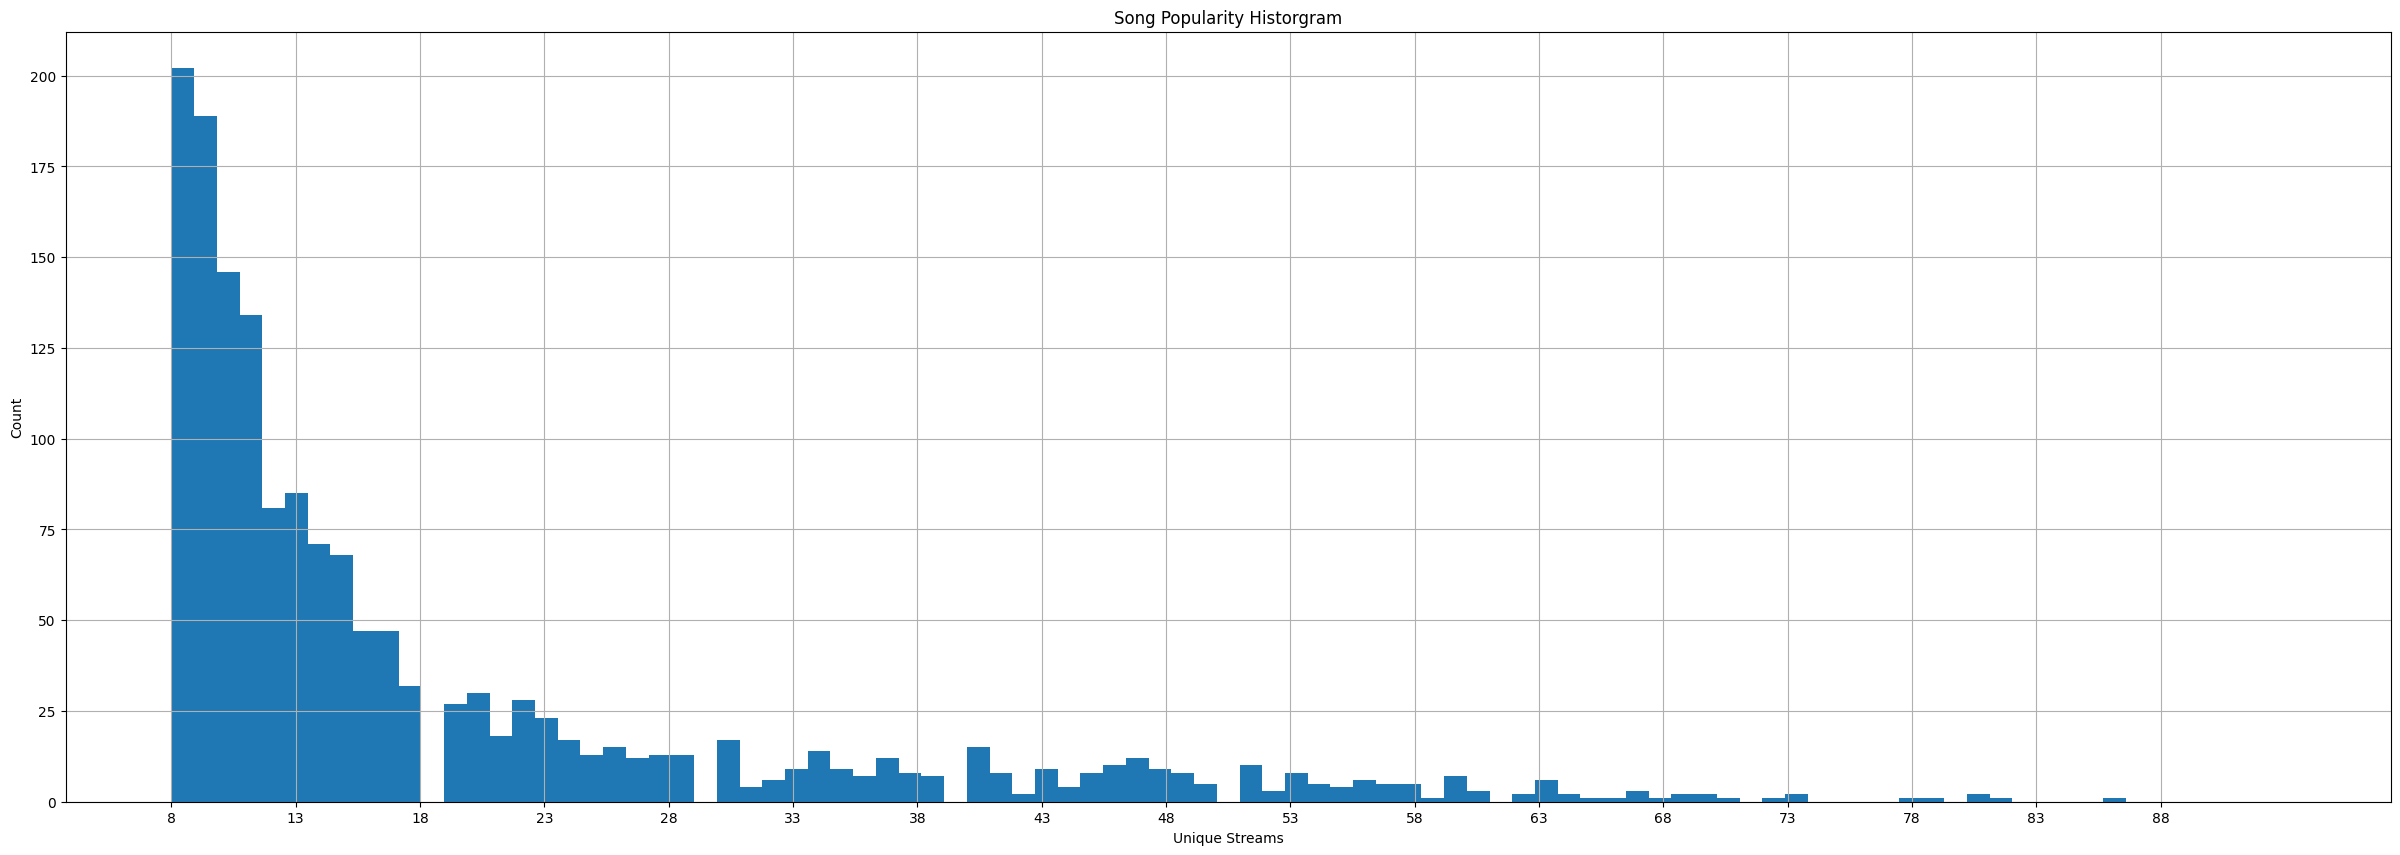

In [19]:
ser = streamHistory[['trackName', 'trackUri', 'reasonEnd']].value_counts()
# ser
# ser.where(ser == 23).dropna()
n = 9
ax = ser.hist(bins=102-n, figsize=(30, 10), range=(8, 102-n))
ax.xaxis.set_ticks(np.arange(8, 102-n, 5))
ax.set(xlabel='Unique Streams', ylabel='Count', title='Song Popularity Historgram')


In [20]:
streamHistory.loc[(streamHistory.trackUri == 'spotify:track:0tPIrbTWGm3vZiBmJSlzID') & (streamHistory.reasonEnd == 'trackdone')].sort_index()

,timeStamp,msPlayed,trackName,artistName,trackUri,reasonStart,reasonEnd,shuffle,skipped,offline,offlineTimestamp
912,2019-05-13 18:53:15+00:00,164576,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,fwdbtn,trackdone,False,NaN,False,1557773429711
1271,2019-06-01 09:46:50+00:00,158186,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,trackdone,trackdone,True,NaN,False,1559382250050
1323,2019-06-06 06:17:08+00:00,158129,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,trackdone,trackdone,True,NaN,False,1559801372365
1531,2019-06-08 21:37:26+00:00,158129,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,trackdone,trackdone,True,NaN,False,1560029687599
1591,2019-06-14 10:24:54+00:00,158129,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,trackdone,trackdone,True,NaN,False,1560507736443
...,...,...,...,...,...,...,...,...,...,...,...
45139,2020-10-20 22:11:29+00:00,158175,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,fwdbtn,trackdone,True,NaN,False,1603231729990
45160,2020-10-21 22:56:48+00:00,158175,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,trackdone,trackdone,True,NaN,False,1603320847816
45517,2020-10-27 20:08:33+00:00,36180,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,remote,trackdone,True,NaN,False,1603829246534
45534,2020-10-27 21:51:51+00:00,36169,Just Wanna Be With You,High School Musical Cast,spotify:track:0tPIrbTWGm3vZiBmJSlzID,appload,trackdone,True,NaN,False,1603835466288


## Isolating Unique Streams

In [21]:
df.drop_duplicates(subset='spotify_track_uri')

NameError: name 'df' is not defined

In [ ]:
2+2